###  Introduction

The PLACES project uses Small Area Estimation (SAE) to predict the prevalence of 27 health & lifestyle measures at Census Designated Places (CDPs) across the US, with populations greater than 50. The 2020 edition contains 28,484 locations totalling 229.6 million people, or ~70% of the US population.

The 27 measures include 5 unhealthy lifestyle choices, 13 chronic diseases, and 9 prevention strategies.

This notebook will explore the relationships between  different health & lifestyle measures, visualise their prevalence per state and utilise a multiple regression model to predict disease prevalence.

__Source__<br>
PLACES 2020 dataset is available [here](https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Place-Data-GIS-Friendly-Format-2020-release/vgc8-iyc4).<br>
Find more information about the PLACES project [here](https://www.cdc.gov/places/about/index.html). <br>
US states shape file is available [here](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html).

In [1]:
import math
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random
from shapely.geometry import Point

In [2]:
pd.set_option('max_columns', 120)
pd.set_option('max_rows', 60)

### Importing / initial cleaning of dataset

In [3]:
raw_df = pd.read_csv('./data/places.csv')

In [4]:
print(raw_df.shape)
raw_df.head(1)

(28484, 118)


StateAbbr StateDesc PlaceName  PlaceFIPS TotalPopulation  ACCESS2_CrudePrev  \
0        AK    Alaska     Wales     282860             145               18.7   

  ACCESS2_Crude95CI  ACCESS2_AdjPrev ACCESS2_Adj95CI  ARTHRITIS_CrudePrev  \
0      (15.1, 22.9)              NaN             NaN                 26.9   

  ARTHRITIS_Crude95CI  ARTHRITIS_AdjPrev ARTHRITIS_Adj95CI  BINGE_CrudePrev  \
0        (25.5, 28.4)                NaN               NaN             18.4   

  BINGE_Crude95CI  BINGE_AdjPrev BINGE_Adj95CI  BPHIGH_CrudePrev  \
0    (16.8, 20.0)            NaN           NaN              37.8   

  BPHIGH_Crude95CI  BPHIGH_AdjPrev BPHIGH_Adj95CI  BPMED_CrudePrev  \
0     (36.2, 39.2)             NaN            NaN             63.1   

  BPMED_Crude95CI  BPMED_AdjPrev BPMED_Adj95CI  CANCER_CrudePrev  \
0    (61.0, 65.3)            NaN           NaN               5.4   

  CANCER_Crude95CI  CANCER_AdjPrev CANCER_Adj95CI  CASTHMA_CrudePrev  \
0     ( 5.1,  5.7)             NaN            NaN               14.0   

  CASTHMA_Crude95CI  CASTHMA_AdjPrev CASTHMA_Adj95CI  CERVICAL_CrudePrev  \
0      (12.9, 15.5)              NaN             NaN                72.7   

  CERVICAL_Crude95CI  CERVICAL_AdjPrev CERVICAL_Adj95CI  CHD_CrudePrev  \
0       (68.7, 76.8)               NaN              NaN           10.5   

  CHD_Crude95CI  CHD_AdjPrev CHD_Adj95CI  CHECKUP_CrudePrev CHECKUP_Crude95CI  \
0  ( 9.5, 11.6)          NaN         NaN               68.9      (67.1, 70.7)   

   CHECKUP_AdjPrev CHECKUP_Adj95CI  CHOLSCREEN_CrudePrev CHOLSCREEN_Crude95CI  \
0              NaN             NaN                  62.9         (59.9, 65.8)   

   CHOLSCREEN_AdjPrev CHOLSCREEN_Adj95CI  COLON_SCREEN_CrudePrev  \
0                 NaN                NaN                    43.9   

  COLON_SCREEN_Crude95CI  COLON_SCREEN_AdjPrev COLON_SCREEN_Adj95CI  \
0           (39.6, 48.4)                   NaN                  NaN   

   COPD_CrudePrev COPD_Crude95CI  COPD_AdjPrev COPD_Adj95CI  COREM_CrudePrev  \
0            13.1   (11.3, 15.0)           NaN          NaN             15.6   

  COREM_Crude95CI  COREM_AdjPrev COREM_Adj95CI  COREW_CrudePrev  \
0    (10.7, 22.2)            NaN           NaN             17.2   

  COREW_Crude95CI  COREW_AdjPrev COREW_Adj95CI  CSMOKING_CrudePrev  \
0    (12.5, 22.8)            NaN           NaN                42.2   

  CSMOKING_Crude95CI  CSMOKING_AdjPrev CSMOKING_Adj95CI  DENTAL_CrudePrev  \
0       (36.1, 46.8)               NaN              NaN              44.0   

  DENTAL_Crude95CI  DENTAL_AdjPrev DENTAL_Adj95CI  DIABETES_CrudePrev  \
0     (38.6, 49.8)             NaN            NaN                17.0   

  DIABETES_Crude95CI  DIABETES_AdjPrev DIABETES_Adj95CI  HIGHCHOL_CrudePrev  \
0       (15.7, 18.3)               NaN              NaN                34.7   

  HIGHCHOL_Crude95CI  HIGHCHOL_AdjPrev HIGHCHOL_Adj95CI  KIDNEY_CrudePrev  \
0       (33.1, 36.2)               NaN              NaN               4.2   

  KIDNEY_Crude95CI  KIDNEY_AdjPrev KIDNEY_Adj95CI  LPA_CrudePrev  \
0     ( 3.8,  4.6)             NaN            NaN           30.1   

  LPA_Crude95CI  LPA_AdjPrev LPA_Adj95CI  MAMMOUSE_CrudePrev  \
0  (26.6, 33.4)          NaN         NaN                69.6   

  MAMMOUSE_Crude95CI  MAMMOUSE_AdjPrev MAMMOUSE_Adj95CI  MHLTH_CrudePrev  \
0       (63.7, 75.3)               NaN              NaN             22.8   

  MHLTH_Crude95CI  MHLTH_AdjPrev MHLTH_Adj95CI  OBESITY_CrudePrev  \
0    (20.3, 25.3)            NaN           NaN               41.0   

  OBESITY_Crude95CI  OBESITY_AdjPrev OBESITY_Adj95CI  PHLTH_CrudePrev  \
0      (38.6, 43.4)              NaN             NaN             23.7   

  PHLTH_Crude95CI  PHLTH_AdjPrev PHLTH_Adj95CI  SLEEP_CrudePrev  \
0    (21.3, 26.5)            NaN           NaN             40.8   

  SLEEP_Crude95CI  SLEEP_AdjPrev SLEEP_Adj95CI  STROKE_CrudePrev  \
0    (38.5, 42.8)            NaN           NaN               5.9   

  STROKE_Crude95CI  STROKE_

In [5]:
# Reducing dataset to only age-adjusted prevalence columns.
df = raw_df.iloc[:, [0,1,2,4]].join(raw_df.filter(regex='.*AdjPrev'))
df.rename(columns=lambda x: x.replace('_AdjPrev', ''), inplace=True)
df.dropna(inplace=True)

print(df.shape)
df.head()

(27240, 32)


StateAbbr   StateDesc    PlaceName TotalPopulation  ACCESS2  ARTHRITIS  \
449        CA  California      Del Rey           1,639     32.2       22.9   
451        AZ     Arizona  Avra Valley           6,050     15.8       24.5   
452        AL     Alabama    Broomtown             182     18.2       35.0   
453        GA     Georgia   Statesboro          28,503     22.9       25.8   
455        CA  California     Dunnigan           1,416     19.6       24.1   

     BINGE  BPHIGH  BPMED  CANCER  CASTHMA  CERVICAL  CHD  CHECKUP  \
449   15.3    34.1   52.0     5.1     10.7      78.4  8.8     68.2   
451   18.8    29.0   55.1     6.5     11.3      83.4  7.0     69.5   
452   13.8    37.8   61.7     6.7     11.7      81.4  9.4     74.5   
453   14.1    36.8   66.3     6.1     10.9      84.3  7.3     79.1   
455   18.0    28.9   51.6     6.1     10.6      83.2  6.6     67.7   

     CHOLSCREEN  COLON_SCREEN  COPD  COREM  COREW  CSMOKING  DENTAL  DIABETES  \
449        74.3          49.4   7.8   17.4   21.0      18.2    44.3      17.4   
451        75.6          61.4   7.7   30.3   24.5      21.7    57.8       9.2   
452        75.2          57.8  12.2   32.1   27.3      27.8    49.4      13.6   
453        79.9          60.0   8.7   29.3   27.3      20.9    52.1      14.6   
455        78.4          63.0   7.5   28.1   28.0      17.7    56.6      11.1   

     HIGHCHOL  KIDNEY   LPA  MAMMOUSE  MHLTH  OBESITY  PHLTH  SLEEP  STROKE  \
449      31.3     4.7  39.1      67.3   17.1     41.4   21.0   39.5     4.6   
451      30.1     3.0  23.8      69.8   15.9     30.0   14.8   35.7     3.4   
452      34.7     3.4  35.5      67.7   21.2     41.1   18.8   38.8     4.4   
453      30.9     3.7  28.6      76.1   16.4     42.4   15.5   41.4     4.4   
455      29.2     3.2  26.3      71.1   15.7     30.4   15.7   32.9     3.7   

     TEETHLOST  
449       22.3  
451       16.9  
452       27.0  
453       20.6  
455       18.2

In [6]:
#df.isnull().sum()
#df.duplicated().any()
#df.dtypes

In [7]:
df.TotalPopulation = df.TotalPopulation.str.replace(',','')
df.TotalPopulation = df.TotalPopulation.astype('int64')

df.describe().round(2)

TotalPopulation   ACCESS2  ARTHRITIS     BINGE    BPHIGH     BPMED  \
count         27240.00  27240.00   27240.00  27240.00  27240.00  27240.00   
mean           8371.46     14.87      25.66     18.66     30.96     56.87   
std           68043.91      6.72       3.78      3.42      5.07      4.07   
min              50.00      4.30      14.30      5.80      6.60     13.60   
25%             419.00     10.50      23.00     16.30     27.50     54.70   
50%            1235.00     13.10      25.40     18.60     30.00     56.80   
75%            4465.25     17.40      28.00     20.90     33.70     59.10   
max         8175111.00     62.10      43.30     30.80     56.70     73.00   

         CANCER   CASTHMA  CERVICAL       CHD   CHECKUP  CHOLSCREEN  \
count  27240.00  27240.00  27240.00  27240.00  27240.00    27240.00   
mean       6.43     10.00     83.82      6.49     73.99       77.55   
std        0.34      1.33      3.54      1.39      3.78        3.40   
min        4.20      5.80     33.30      3.30     62.10       21.80   
25%        6.40      9.10     82.60      5.50     71.60       75.30   
50%        6.50      9.90     84.20      6.30     74.30       77.50   
75%        6.60     10.70     85.80      7.30     76.50       79.80   
max        7.30     20.40     91.80     16.50     85.80       88.90   

       COLON_SCREEN      COPD     COREM     COREW  CSMOKING    DENTAL  \
count      27240.00  27240.00  27240.00  27240.00  27240.00  27240.00   
mean          63.39      7.40     31.98     28.18     20.41     62.55   
std            5.96      2.17      6.34      5.35      5.21      9.16   
min           34.00      2.40      3.20      3.90      5.30     27.60   
25%           60.10      5.80     27.90     24.60     17.10     56.50   
50%           63.90      7.20     32.50     28.40     20.40     63.40   
75%           67.40      8.70     36.10     31.60     23.70     69.00   
max           80.50     21.50     52.90     48.50     51.10     85.40   

       DIABETES  HIGHCHOL    KIDNEY       LPA  MAMMOUSE     MHLTH   OBESITY  \
count  27240.00  27240.00  27240.00  27240.00  27240.00  27240.00  27240.00   
mean      10.27     29.64      2.79     25.43     71.23     14.87     33.69   
std        2.87      2.29      0.58      6.21      4.94      2.79      5.52   
min        4.60      6.30      1.70      8.10     26.20      6.90     13.10   
25%        8.30     28.20      2.40     21.20     68.70     12.80     30.40   
50%        9.60     29.60      2.70     24.80     71.60     14.80     34.10   
75%       11.50     31.10      3.00     29.30     74.50     16.70     37.20   
max       26.20     37.40      7.00     54.20     85.50     32.10     57.00   

          PHLTH     SLEEP    STROKE  TEETHLOST  
count  27240.00  27240.00  27240.00   27240.00  
mean      13.21     36.37      3.23      16.23  
std        3.34      4.28      0.88       6.30  
min        5.40     23.40      1.50       2.80  
25%       10.80     33.30      2.70      11.90  
50%       12.80     36.20      3.00      15.30  
75%       15.10     39.20      3.60      19.60  
max       38.20     55.30     10.30      63.00

In [8]:
# Making column names more readable when plotting.
column_long_name = ['State abbreviation', 'State name', 'Place name', 'Total population', 
                    'Lack of health insurance', 'Arthritis', 'Binge drinking', 'High blood pressure',
                    'Blood pressure medication', 'Cancer', 'Asthma', 'Cervical cancer screening', 'CHD',
                    'Routine medical checkups', 'Cholesterol screening', 'Colon screening', 'COPD', 
                    'Older men medical checkups', 'Older women medical checkups', 'Smoking',
                    'Dental checkups', 'Diabetes', 'High cholesterol', 'Kidney disease',
                    'Low physical activity', 'Mammography usage', 'Poor mental health', 
                    'Obesity', 'Poor physical health', '<7 hours sleep', 'Stroke', 'All teeth lost']
column_name_dict = {}
for key, value in zip(df.columns, column_long_name):
    column_name_dict[key] = value

<br>

---

<br>

### Mapping data collection locations and their population size

In [9]:
location_df = raw_df.loc[:, ['StateDesc', 'PlaceName', 'TotalPopulation', 'Geolocation']]
location_df.TotalPopulation = location_df.TotalPopulation.str.replace(',','')
location_df.TotalPopulation = location_df.TotalPopulation.astype('int64')

# Scaled down TotalPopulation in order to define location marker size.
location_df['City_Size'] = (location_df.TotalPopulation ** 0.5) / 25

# Changing geolocation column from string to float.
x = []
y = []
for datapoint in location_df.Geolocation:
    
    split_data = datapoint.split(' ')
    x.append(float(split_data[1].replace('(', '')))
    y.append(float(split_data[2].replace(')', '')))

# Making geolocation data plottable using GeoPandas.
location_gdf = gpd.GeoDataFrame(location_df.iloc[:, [0,1,2,4]], geometry=gpd.points_from_xy(x, y))

In [10]:
# Importing shape file for the United States into GeoPandas, removing US territories.
states_gdf = gpd.read_file('./shapefiles/US_states/cb_2018_us_state_500k.shp')
states_gdf = states_gdf[states_gdf.NAME.isin(location_df.StateDesc.unique()) == True]
states_gdf.head(1)

STATEFP   STATENS     AFFGEOID GEOID STUSPS         NAME LSAD         ALAND  \
0      28  01779790  0400000US28    28     MS  Mississippi   00  121533519481   

       AWATER                                           geometry  
0  3926919758  MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...

__Mainland US__

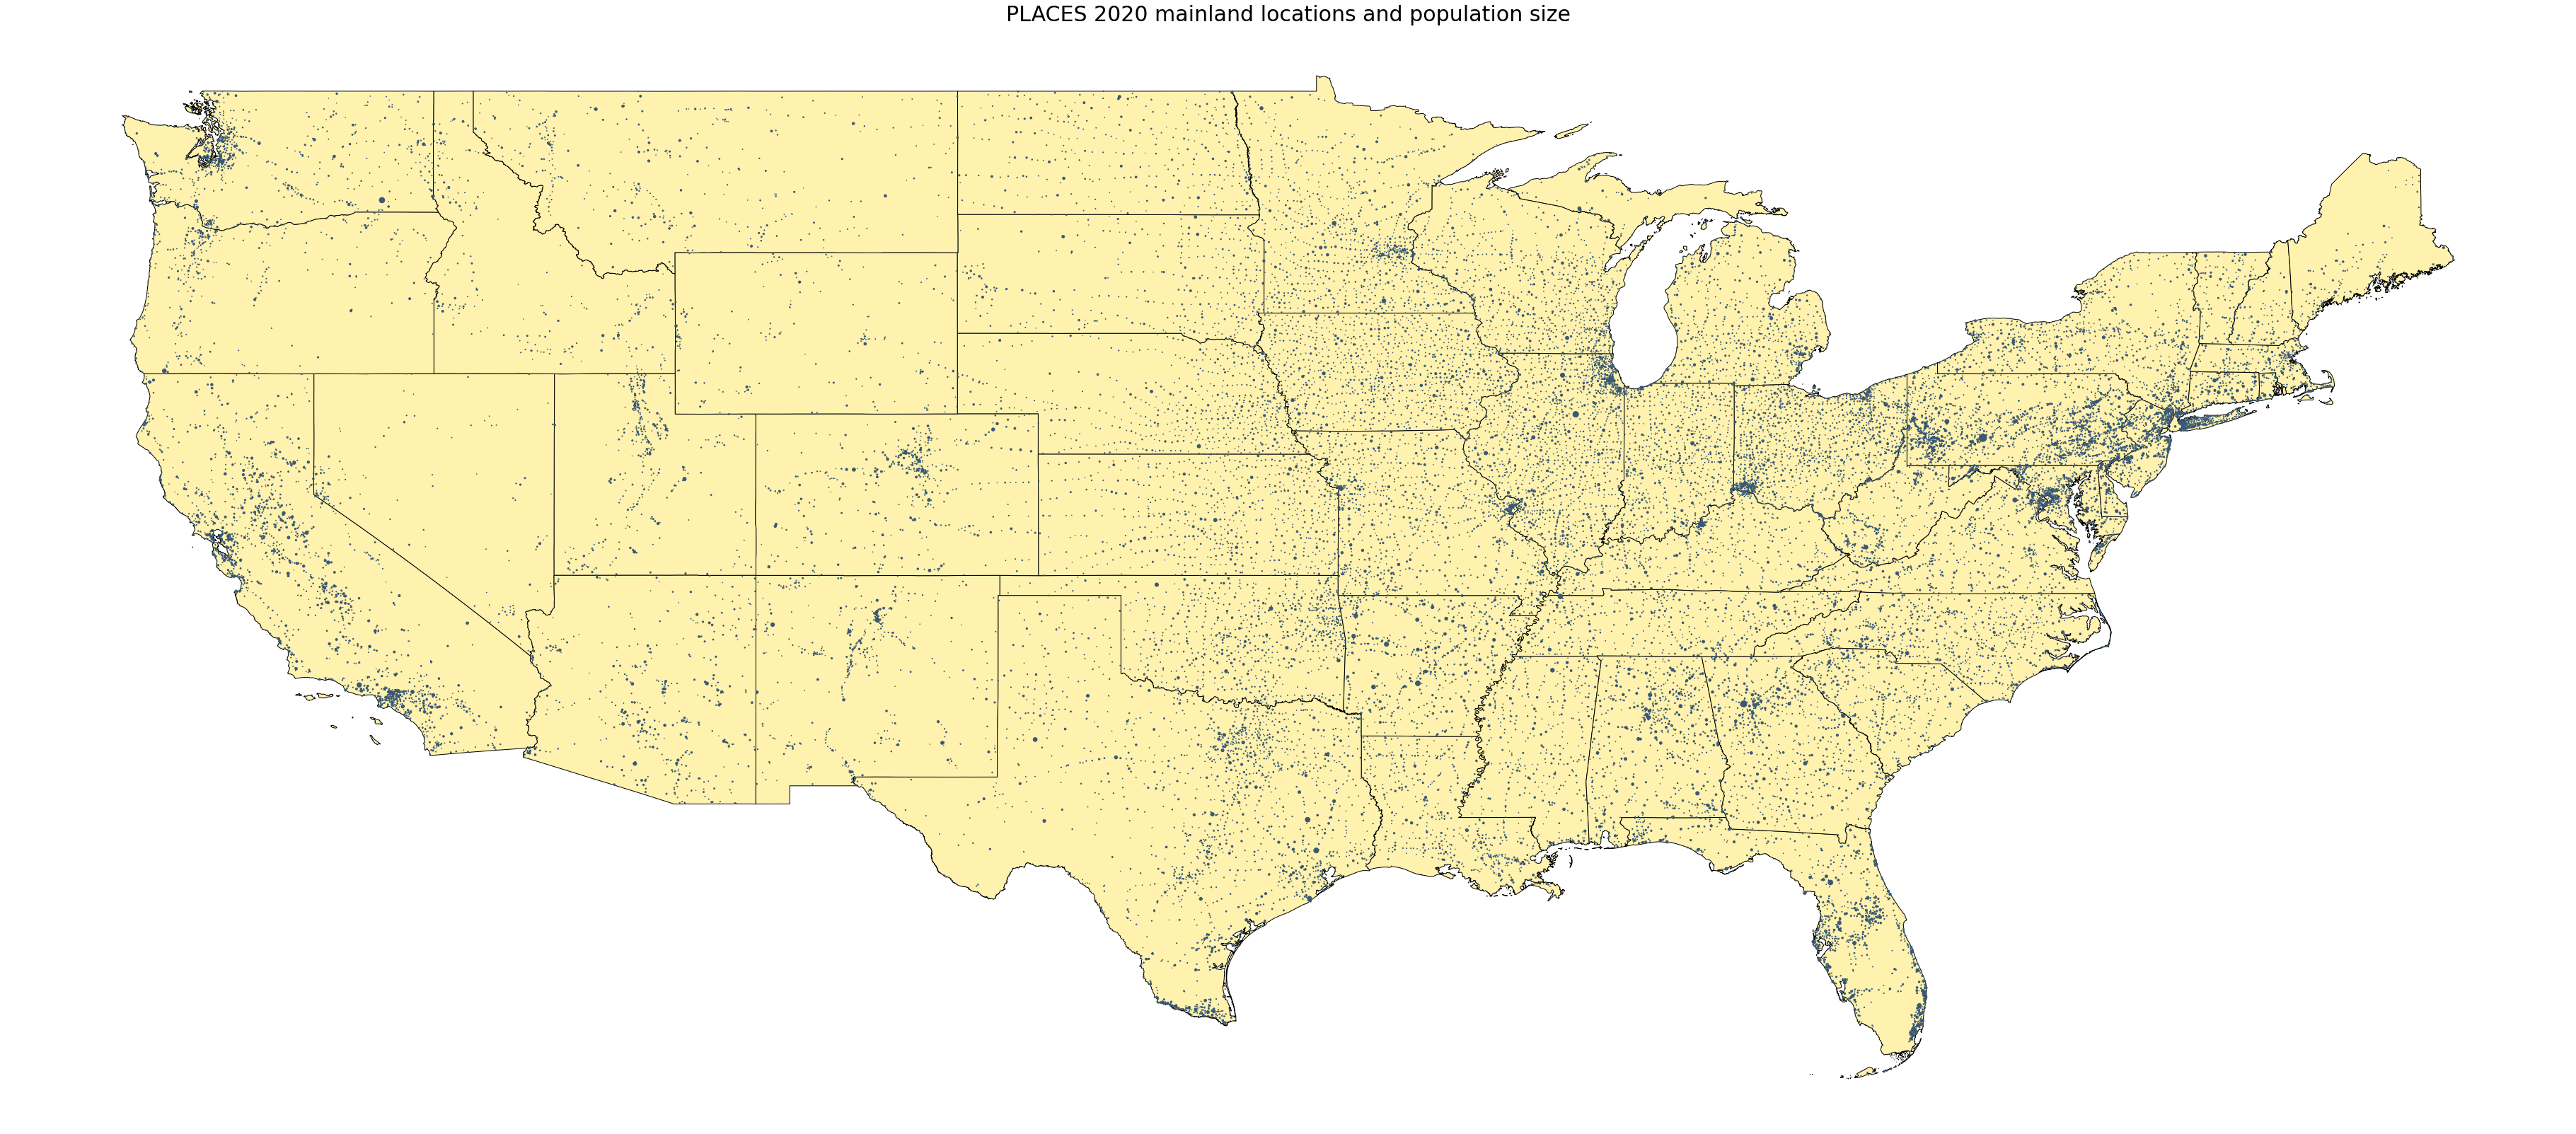

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(65,65)  
    
states_gdf[states_gdf.NAME.isin(['Hawaii', 'Alaska']) == False].plot(
    color='#FFF2AF', edgecolor='black', ax=ax)

location_gdf[location_gdf.StateDesc.isin(['Hawaii', 'Alaska']) == False].plot(
    color='#3A5874', ax=ax, markersize=(location_gdf.TotalPopulation ** 0.5) / 25)

ax.set_title('PLACES 2020 mainland locations and population size', fontsize=30)

plt.axis('off')
plt.show()

        ** save image or open in new tab for full resolution **

__All US states__ <br>
(available in '*images*' folder)

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(150,150)  
    
states_gdf.plot(color='#FFF2AF', edgecolor='black', ax=ax)
location_gdf.plot(color='#3A5874', ax=ax, markersize=(location_gdf.TotalPopulation ** 0.5) / 25)

ax.set_xlim(-180,-66)
ax.set_ylim(18,72)
plt.axis('off')

#plt.savefig('PLACES_2020_Geolocations')

plt.clf()

<Figure size 10800x10800 with 0 Axes>

<br>

---

<br>

### Exploring relationships between all health & lifestyle measures

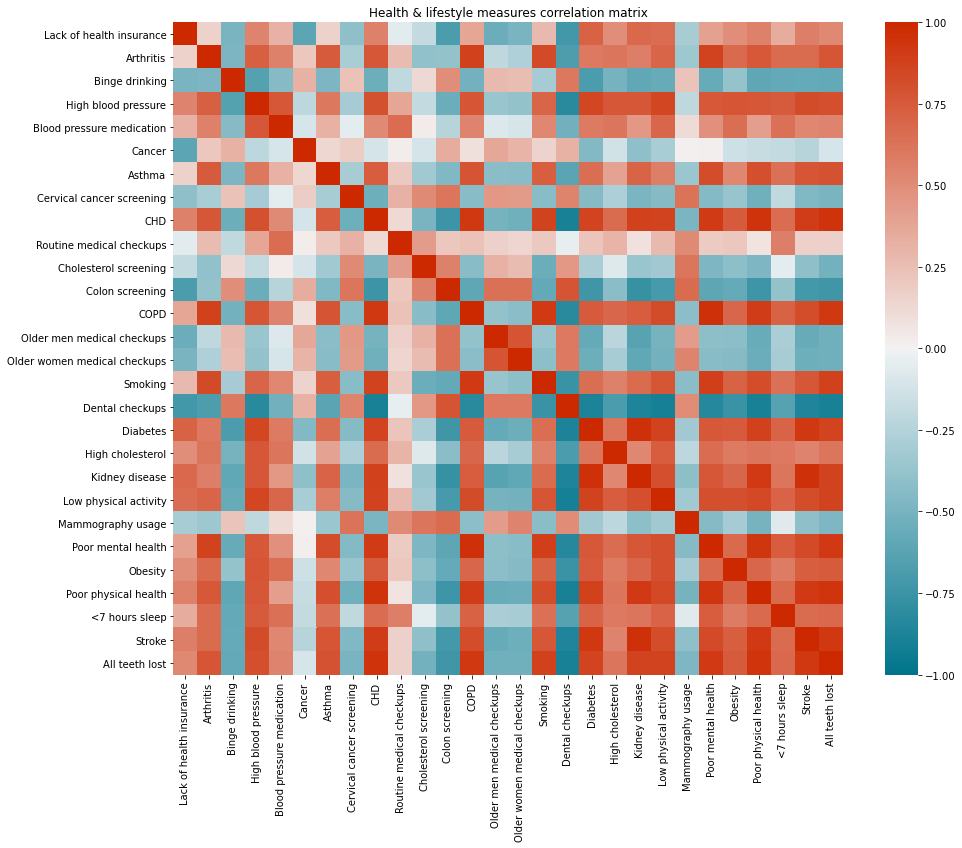

In [13]:
corr = df.iloc[:, 4:].corr()
corr.columns = list(column_name_dict.values())[4:]
corr.index = list(column_name_dict.values())[4:]

fig, ax = plt.subplots()
fig.set_size_inches(15,12)

sns.heatmap(corr, ax=ax, vmax=1, center=0, vmin=-1,
            cmap=sns.diverging_palette(220, 15, s=100, l=45, as_cmap=True))

ax.set_title('Health & lifestyle measures correlation matrix')

plt.show()

__Notable correlations__

Many well known relationships between chronic diseases and lifestyle risk factors are evident in this correlation matrix, such as the positive correlation between obesity and CHD, or between smoking and COPD.

One interesting finding is a lack of correlation between cancer and almost all other measures, especially smoking, suggesting the majority of variation in cancer prevalence can be attributed to other factors not available in this dataset such as age or sun exposure.

Another unexpected finding is the strength of negative correlations between dental checkups and almost all negative lifestyle choices and chronic diseases. As it is very unlikely that a causal link exists between dental checkups and e.g. increased physical activity, these correlations are presumably a result of personality traits in which individuals who are less concerned with their general physical health probably aren't concerned with their dental health either.

The negative correlations between binge-drinking and many chronic diseases and their associated risk factors is also surprising. This is likely to be a result of regional differences, as is apparent when mapping the prevalence of each measure per state. Midwestern states, particularly Wisconsin have a higher prevalence of binge-drinking, but a relatively low prevalence of obesity and low physical activity. <br>
It is also important to note that the definition of binge-drinking in this dataset is "five or more drinks (men) or four or more drinks (women) on an occasion in the past 30 days", which may not always equate to the alcohol intake required to increase disease prevalence.

<br>

---

<br>

###  Plotting linear regressions between diseases and their major predictive risk factors

In [14]:
def plot_variables_disease_relationship(df, disease, variables, figure_size_tuple):
    
    rows = math.ceil(len(variables) / 2) # Calculating necessary number of rows of subplots.
    
    subplot=1
    fig = plt.figure(figsize=figure_size_tuple)
    
    for column in variables:
        ax = fig.add_subplot(rows, 2, subplot)
        ax.scatter(df[column], df[disease], s=25, marker='.', alpha=0.3, edgecolors='none')
        ax.set_title('{0} - {1}'.format(column_name_dict[disease], column_name_dict[column]))
        ax.set_xlabel('{} (%)'.format(column_name_dict[column]))
        ax.set_ylabel('{} (%)'.format(column_name_dict[disease]))
        
        # Retrieving R-squared value and slope-intercept of the regression line.
        result = linregress(df[column], df[disease])
        
        ax.text(0.35, 0.93,'y = {0}x + {1}'.format(
            round(result.slope,3), round(result.intercept,3)), transform=ax.transAxes, fontsize=11)
        
        ax.text(0.42, 0.89, 'R² = {}'.format(
            round(result.rvalue**2, 3)), transform=ax.transAxes, fontsize=11)
        
        # Not plotting regression lines for very weak relationships. 
        if result.rvalue**2 > 0.1: 
            ax.plot(df[column], result.slope*df[column]+result.intercept, color='black')
        
        subplot += 1
    
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

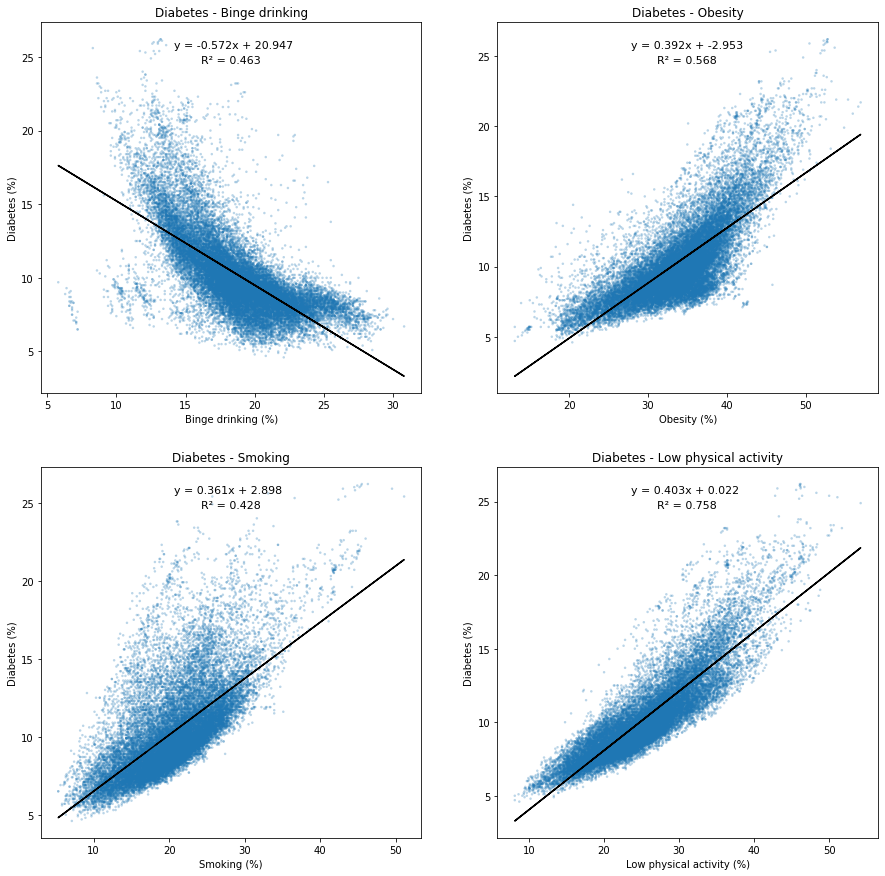

In [15]:
plot_variables_disease_relationship(df, 'DIABETES', ['BINGE', 'OBESITY', 'CSMOKING', 'LPA'], (15,15))

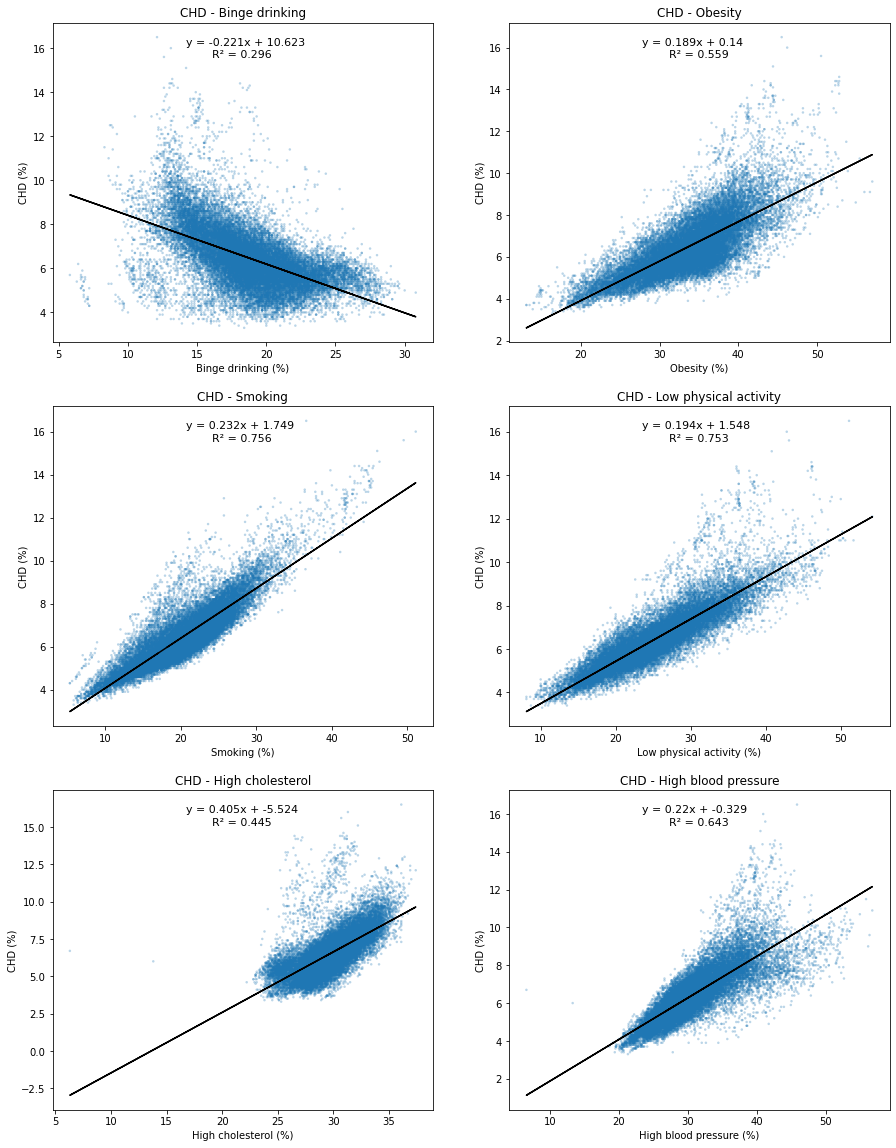

In [16]:
plot_variables_disease_relationship(df, 'CHD',
                                    ['BINGE', 'OBESITY', 'CSMOKING', 'LPA', 'HIGHCHOL', 'BPHIGH'], (15,20))

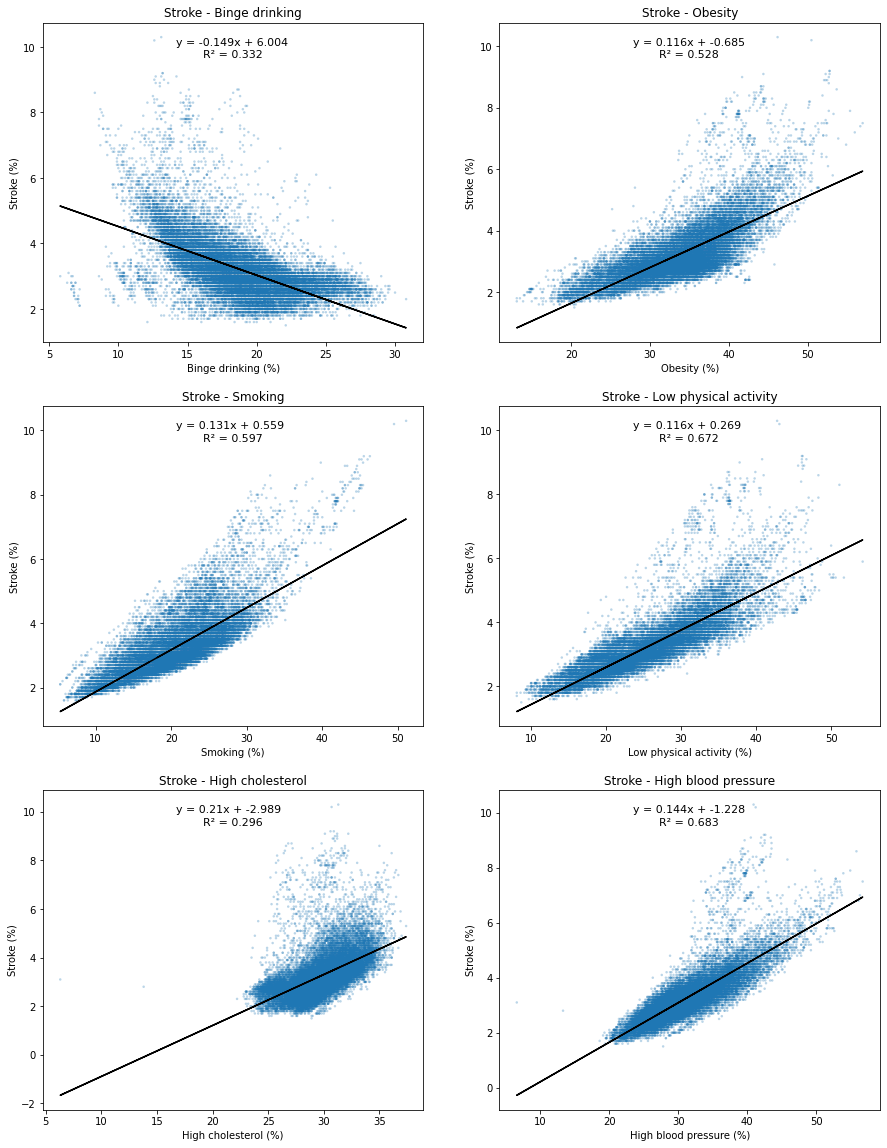

In [17]:
plot_variables_disease_relationship(df, 'STROKE',
                                    ['BINGE','OBESITY', 'CSMOKING', 'LPA', 'HIGHCHOL', 'BPHIGH'], (15,20))

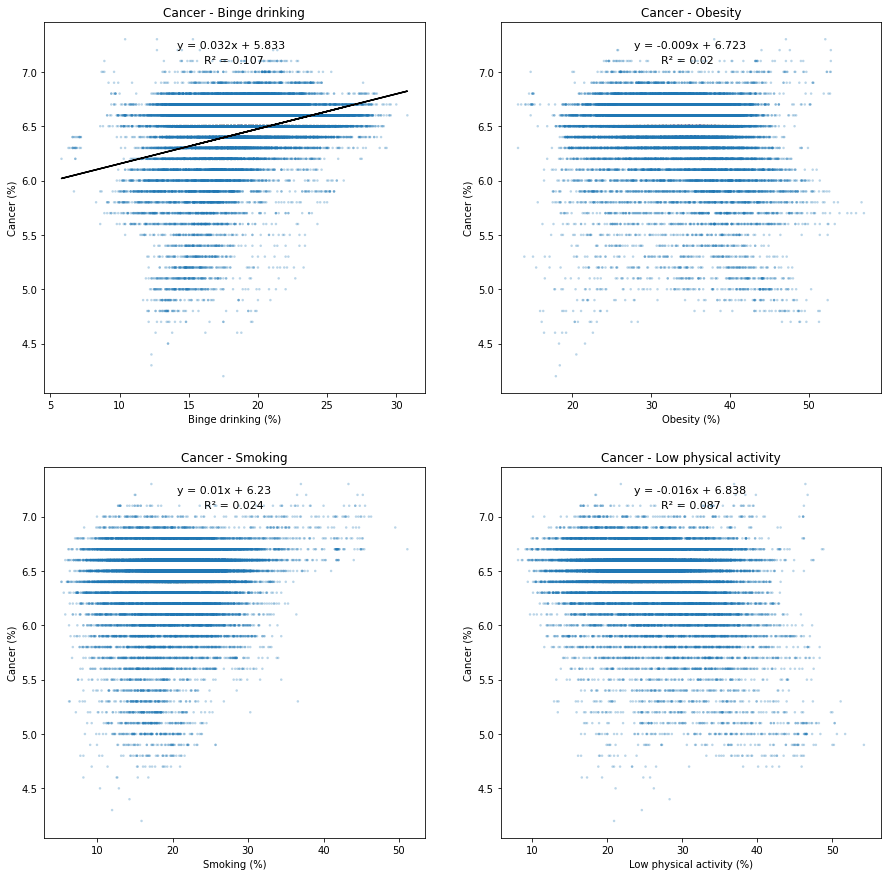

In [18]:
plot_variables_disease_relationship(df, 'CANCER', ['BINGE', 'OBESITY', 'CSMOKING', 'LPA'], (15,15))

                *white banding caused by small variation (4.5-7%) coupled with low precision values*

<br>

---

<br>

### Predicting disease prevalence using multiple lifestyle risk factors with a multiple regression

In [19]:
def predict_disease_prevalence(df, disease, specify_predictors):
    """Splits input data into test and train, creates a regression model,
        returns performance metrics."""

    train_data, test_data, train_labels, test_labels = train_test_split(
        df[specify_predictors], df[disease], train_size=0.8, test_size=0.2, random_state=6)

    regressor = LinearRegression()
    regressor.fit(train_data, train_labels)

    train_score = regressor.score(train_data, train_labels)
    test_score = regressor.score(test_data, test_labels)
    test_RMSE = mean_squared_error(test_labels, regressor.predict(test_data))
    
    coefficients = pd.DataFrame(
        data=regressor.coef_, index=df[specify_predictors].columns, columns=['coefficients/slopes'])

                       
    print('train R-squared : {}'.format(round(train_score,3)))
    print('test R-squared : {}'.format(round(test_score,3)))
    print('test RMSE: {}'.format(round(test_RMSE, 3)))
    print() 
    print(coefficients.round(3))

In [20]:
predict_disease_prevalence(df=df, disease='DIABETES',
                           specify_predictors=['BINGE', 'CSMOKING', 'OBESITY', 'LPA'])

train R-squared : 0.826
test R-squared : 0.824
test RMSE: 1.355

          coefficients/slopes
BINGE                  -0.251
CSMOKING               -0.004
OBESITY                 0.106
LPA                     0.253


__With access to prevalence data of four major lifestyle risk factors for diabetes; binge-drinking, smoking, obesity and low physical activity, we could predict 82.4% of the variation in diabetes prevalence.__

In [21]:
predict_disease_prevalence(df=df, disease='CHD',
                           specify_predictors=['BINGE', 'CSMOKING', 'OBESITY', 'LPA'])

train R-squared : 0.871
test R-squared : 0.869
test RMSE: 0.238

          coefficients/slopes
BINGE                  -0.075
CSMOKING                0.146
OBESITY                 0.008
LPA                     0.071


In [22]:
predict_disease_prevalence(df=df, disease='STROKE',
                           specify_predictors=['BINGE', 'CSMOKING', 'OBESITY', 'LPA'])

train R-squared : 0.764
test R-squared : 0.759
test RMSE: 0.173

          coefficients/slopes
BINGE                  -0.066
CSMOKING                0.067
OBESITY                 0.021
LPA                     0.038


In [23]:
predict_disease_prevalence(df=df, disease='CANCER',
                           specify_predictors=['BINGE', 'CSMOKING', 'OBESITY', 'LPA'])

train R-squared : 0.462
test R-squared : 0.45
test RMSE: 0.057

          coefficients/slopes
BINGE                   0.006
CSMOKING                0.061
OBESITY                 0.002
LPA                    -0.056


<br>

---

<br>

### Exploring differences in health & lifestyle measures between states

In [24]:
states_aggr_df = df.groupby('StateAbbr')[df.columns[4:]].mean()

print(states_aggr_df.shape)
states_aggr_df.head().round(2)

(51, 28)


ACCESS2  ARTHRITIS  BINGE  BPHIGH  BPMED  CANCER  CASTHMA  \
StateAbbr                                                              
AK           15.25      27.15  17.38   33.91  49.50    6.55    11.85   
AL           16.90      31.24  14.25   39.41  62.38    6.49    10.90   
AR           15.22      29.80  15.56   37.08  60.46    6.52    10.51   
AZ           16.27      26.10  16.73   31.26  53.96    6.43    12.30   
CA           14.51      22.10  19.14   27.77  50.65    6.09     9.59   

           CERVICAL   CHD  CHECKUP  CHOLSCREEN  COLON_SCREEN  COPD  COREM  \
StateAbbr                                                                   
AK            80.08  8.46    69.75       70.28         51.08  9.58  21.08   
AL            84.67  7.72    76.60       78.33         64.74  9.28  33.07   
AR            82.36  7.88    76.71       75.70         59.64  9.03  26.33   
AZ            80.46  7.90    69.90       75.24         52.76  9.17  22.83   
CA            83.36  5.77    69.04       79.22         66.08  6.08  30.18   

           COREW  CSMOKING  DENTAL  DIABETES  HIGHCHOL  KIDNEY    LPA  \
StateAbbr                                                               
AK         21.31     28.63   57.29     13.17     29.17    3.60  25.74   
AL         29.87     22.97   56.10     13.05     33.08    3.18  31.39   
AR         22.50     25.03   53.20     12.06     31.41    3.09  33.78   
AZ         19.46     23.09   53.58     12.19     29.06    3.68  26.51   
CA         29.91     14.81   63.60      9.91     28.49    2.88  21.75   

           MAMMOUSE  MHLTH  OBESITY  PHLTH  SLEEP  STROKE  TEETHLOST  
StateAbbr                                                             
AK            61.00  16.98    34.77  17.73  36.49    4.71      25.92  
AL            74.37  17.70    37.35  15.56  39.56    4.00      20.94  
AR            68.56  17.09    36.82  16.51  36.74    3.85      22.91  
AZ            62.16  16.95    33.58  17.87  37.70    4.36      21.71  
CA            72.82  13.91    28.12  13.60  33.52    3.06      12.97

In [25]:
# Joining state aggregated dataset with US state shape file.
states_aggr_gdf = states_gdf.set_index('STUSPS').join(states_aggr_df).reset_index()

In [26]:
def plot_by_state(states_aggr_gdf, variable, all_states=False, labels=True, legend=True):
    """Plots the prevalence of a risk factor per state."""
    
    fig, ax = plt.subplots()
    fig.set_size_inches(17,17)  
    
    if all_states == False:
        states_aggr_gdf = states_aggr_gdf[states_aggr_gdf.NAME.isin(['Alaska', 'Hawaii'])== False]
    else:
        ax.set_xlim(-180,-66)
        ax.set_ylim(18,72)
        
    if legend == True:
        states_aggr_gdf.plot(column=variable, cmap='Reds', edgecolor='black', ax=ax, legend=True,
                             legend_kwds={'label': "Mean prevalence (%)",
                                          'orientation': "horizontal",
                                          'shrink':0.8, 'pad':0})
    else:
        states_aggr_gdf.plot(column=variable, cmap='Reds', edgecolor='black', ax=ax)
    
    if labels == True:
        # Placing the name of each state at the central point of it's geometry.
        states_aggr_gdf.apply(lambda x: ax.annotate(text=x.STUSPS, xy=x.geometry.centroid.coords[0],
                                                    ha='center', fontsize=10, fontweight='bold'), axis=1)
    
    is_abbrev = lambda x: x if x == 'COPD' or x == 'CHD' else x.lower()
    ax.set_title('Mean urban prevalence of {}'.format(is_abbrev(column_name_dict[variable])),
                 fontsize=13, fontweight='semibold')
    plt.axis('off')
    plt.show()

### Unhealthy lifestyle prevalence per state

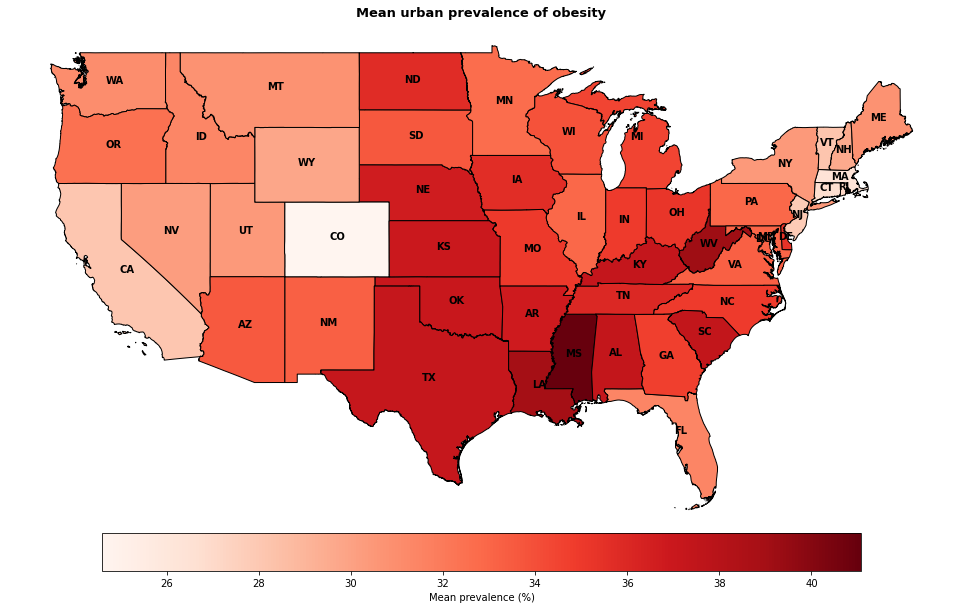

In [27]:
plot_by_state(states_aggr_gdf, 'OBESITY')

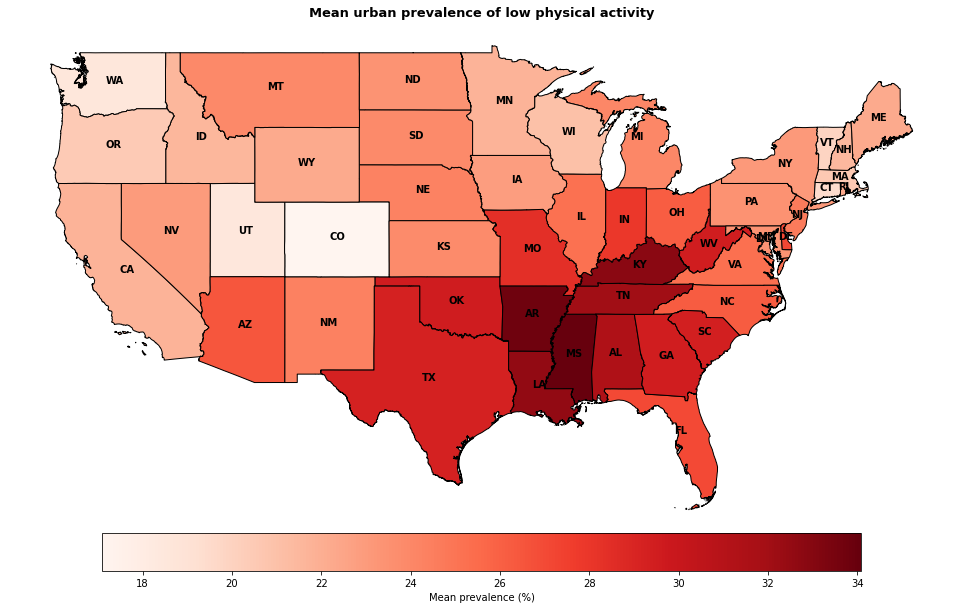

In [28]:
plot_by_state(states_aggr_gdf, 'LPA')

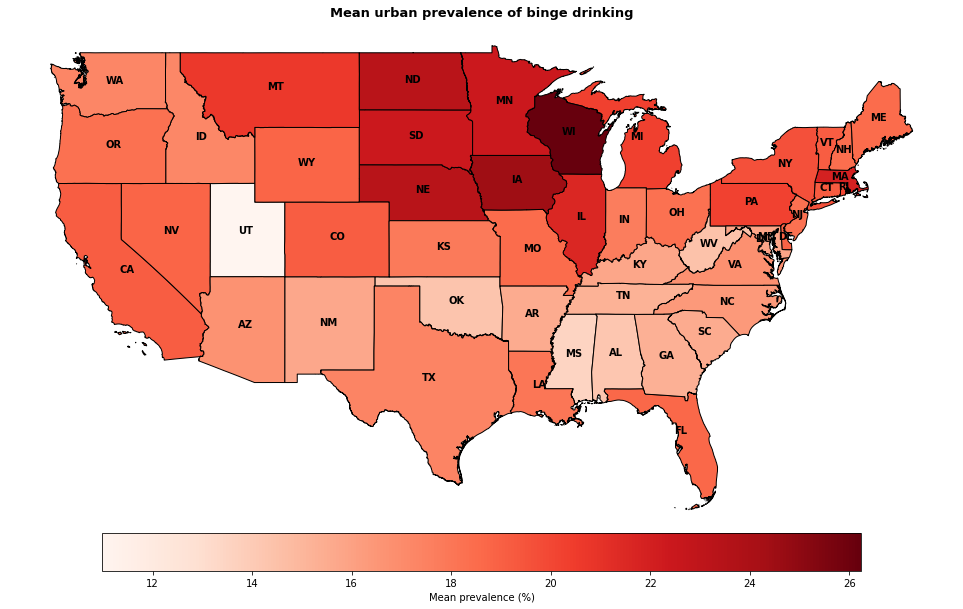

In [29]:
plot_by_state(states_aggr_gdf, 'BINGE')

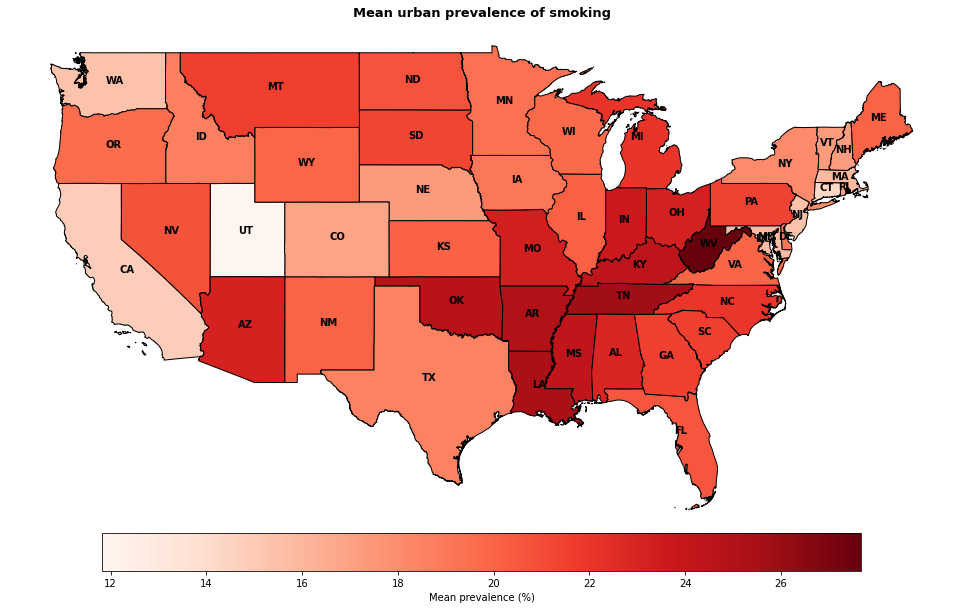

In [30]:
plot_by_state(states_aggr_gdf, 'CSMOKING')

<br>

---

<br>

### Disease prevalence

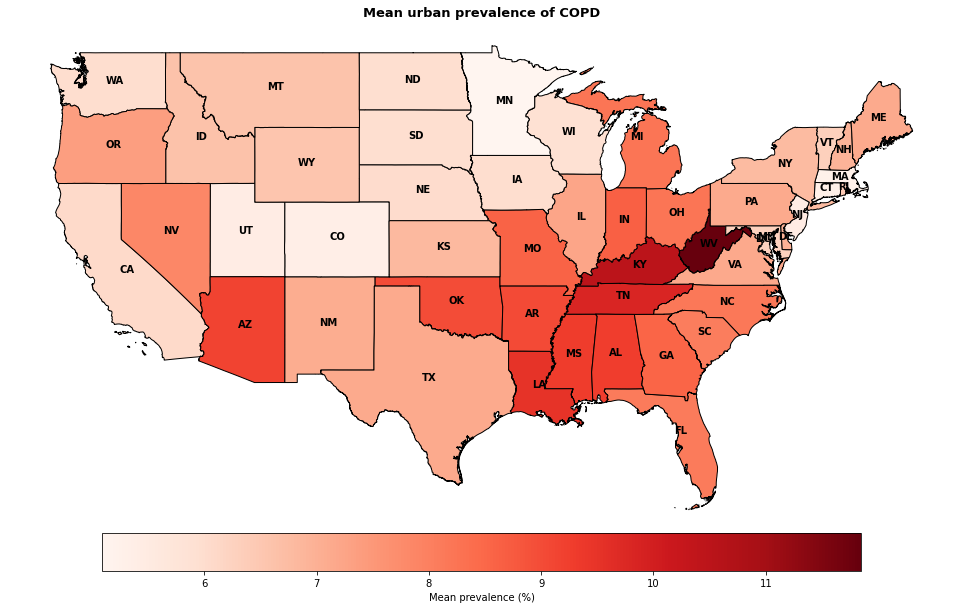

In [31]:
plot_by_state(states_aggr_gdf, 'COPD')

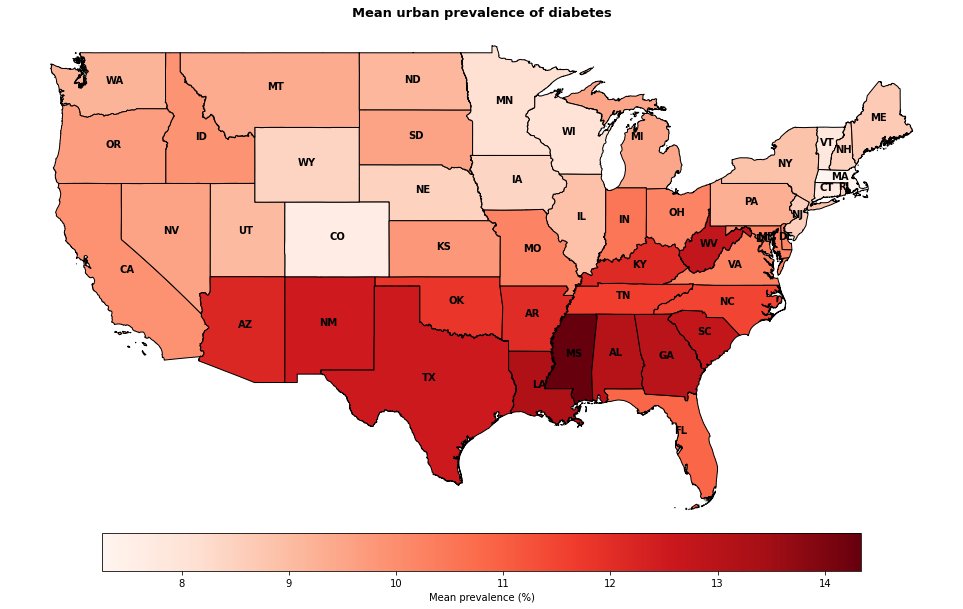

In [32]:
plot_by_state(states_aggr_gdf, 'DIABETES')

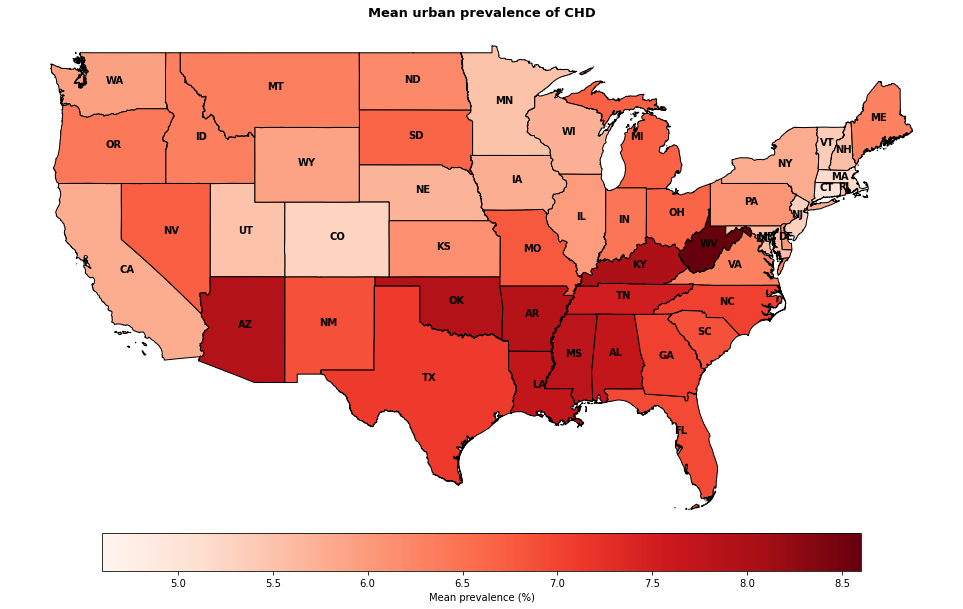

In [33]:
plot_by_state(states_aggr_gdf, 'CHD')

### Notable observations

As expected, states with a high prevalence of lifestyle risk factors for a disease, also have a high prevalence of said disease. <br>
This is particularly evident in West Virginia (WV) which has the highest prevalence of smoking, a major risk factor for COPD, a disease which is also most prevalent in West Virginia.

A possible explanation for the negative correlation between binge-drinking and many chronic diseases is evident here. Midwestern states while having a higher prevalence of binge drinking, have much a lower prevalence of other lifestyle risk factors for most diseases in this dataset.